In [1]:
# Required packages
import pandas as pd
import numpy as np
import geopandas as gpd

# date and time
import datetime

# JSON
import json
import os

# Progress Bar
from IPython.core.display import Image, display
import progressbar

# Plots

import seaborn as sns
import matplotlib.pyplot as plt

import geoplot as gplt
import geoplot.crs as gcrs
import mplleaflet
from shapely.geometry import Point, Polygon

import folium
from folium import plugins
from folium.plugins import HeatMap

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})

# plt setting
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Calgary Property Assessments

The assessed values of residential, non-residential and farm land properties in Calgary. The properties in this dataset consist of Calgary lands that have a registered parcel at Alberta’s Land Titles Office. Properties that are on The City of Calgary’s annual property assessment rolls, but excluded from this dataset, are titled parking stalls, titled storage units, machinery & equipment property, and linear property (as defined in the Municipal Government Act). This dataset can be downloaded from [here](https://data.calgary.ca/dataset/Property-Assessments/6zp6-pxei).

For detailed property assessment information, visit https://assessmentsearch.calgary.ca

#### Table of contents

* [Property Assessments](#Property-Assessments)
* [Datasets](#Datasets)
* [Data Analysis](#Data-Analysis)
    * [Average Price (the Current Year)](#Average-Price-(the-Current-Year))
        * [Average Price (Non-residential)](#Average-Price-(Non-residential))
        * [Average Price (Residential)](#Average-Price-(Residential))
        * [Average Price (Farmland)](#Average-Price-(Farmland))
        * [Average Price (Machinery And Equipment)](#Average-Price-(Machinery-And-Equipment))
        * [Assessed Average Value by Sector](#Assessed-Average-Value-by-Sector)
        * [Assessed Average Value by Community Structure](#Assessed-Average-Value-by-Community-Structure)
    * [Maps](#Maps)
        * [Assessed Average Value by Community](#Assessed-Average-Value-by-Community)
        * [Asset Values in Each Community](#Asset-Values-in-Each-Community)
* [Predictions](#Predictions)

# Datasets

In [2]:
file = 'Calgary/Property_Assessments_Clean.csv'
Data = pd.read_csv(file)
Temp = os.stat(file).st_size/(1024 **3)
print('File Size in GigaBytes is %1.2f' % Temp)
del file, Temp

File Size in GigaBytes is 1.31


In [3]:
Data.head(4).style.hide_index()

We can also use the community boundaries for the city of Calgary from [here](https://data.calgary.ca/Base-Maps/Community-Boundaries/ab7m-fwn6).

In [4]:
Community_Boundaries = gpd.read_file('Calgary/Community_Boundaries.geojson')
# Chaning the headers to title
mylist = Community_Boundaries.columns.tolist()
mylist = [x.title() for x in mylist]
mylist = [x.replace('Geometry','geometry') for x in mylist]
Community_Boundaries.columns = mylist
del mylist

In [5]:
Community_Boundaries.head(4)

Comm_Structure          Name     Sector Class_Code         Srg  \
0     INNER CITY       SUNALTA     CENTRE          1   BUILT-OUT   
1   BUILDING OUT  WEST SPRINGS       WEST          1  DEVELOPING   
2          OTHER           12A  SOUTHEAST          4         N/A   
3          1950s  WINDSOR PARK     CENTRE          1   BUILT-OUT   

               Class Comm_Code  \
0        Residential       SNA   
1        Residential       WSP   
2  Residual Sub Area       12A   
3        Residential       WND   

                                            geometry  
0  POLYGON ((-114.10061493005 51.047994301993, -1...  
1  POLYGON ((-114.187805990867 51.061506344418, -...  
2  POLYGON ((-113.869446537594 50.979572332142, -...  
3  POLYGON ((-114.081517547811 51.008716296692, -...

# Data Analysis

First, of all

In [6]:
Years = np.sort(Data.Roll_Year.unique())
Years.min(), Years.max()

(2005, 2019)

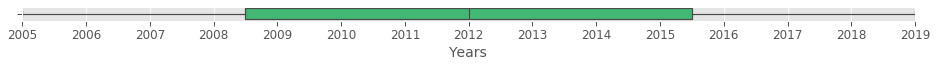

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 0.25), sharex=False)
sns.boxplot(x=Years, ax=ax, orient='h', color='#2ecc71')
_ = ax.set_xlabel('Years')
_ = ax.set_xlim([Years.min(), Years.max()])
_ = ax.set_xticks(Years)

In particular, in each year:

In [8]:
Group = Data.groupby('Roll_Year')['Unique_Key'].agg({'Count': 'count'})
Group.T

Roll_Year    2005    2006    2007    2008    2009    2010    2011    2012  \
Count      361362  376124  388977  406818  424240  431813  441823  448080   

Roll_Year    2013    2014    2015    2016    2017    2018    2019  
Count      460129  468200  478339  493405  505988  525865  536068

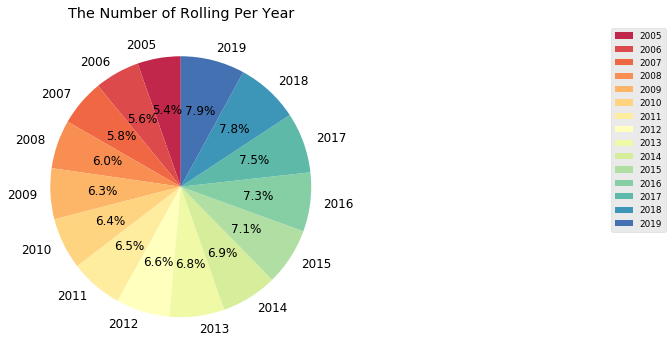

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
_ = Group.plot.pie(y='Count', startangle=90, legend=False,label='',ax=ax, autopct='%1.1f%%',
                   colors = sns.color_palette("Spectral", len(Group)), fontsize=12)
_ = ax.legend(bbox_to_anchor=(2, 1))
_ = ax.set_title('The Number of Rolling Per Year')

Now, let's define some functions

In [10]:
def address_map(Inp, Zoom=12.5, Icon='info-sign'):
    m = folium.Map(location=[Temp.Latitude[0], Temp.Longitude[0]], zoom_start=Zoom)
    folium.Marker(location=[Temp.Latitude[0], Temp.Longitude[0]],popup = Temp.Address[0],
                  icon=folium.Icon(icon=Icon)).add_to(m)
    return m 

In [11]:
def Roll_Number_Data (Roll_Number):
    Out = Data[Data.Roll_Number == Roll_Number].sort_values(by='Roll_Year',
                                                                ascending=True).reset_index(drop =True)
    return Out

In [12]:
def Roll_Number_Table(Inp):
    Out = Inp[['Roll_Year','Assessed_Value','Assessment_Class_Description']]
    Out = Out.rename(columns={'Roll_Year':'Year','Assessed_Value':'Value','Assessment_Class_Description':'Class'})
    Out = Out.set_index('Year')
    Out = Out.T
    return Out 

In [13]:
def Unit_Price(Inp):
    fig, ax = plt.subplots(figsize=(14,5))
    fig = sns.regplot(x='Roll_Year', y='Assessed_Value', data=Inp, color='#e74c3c',
                      scatter_kws={'s': 50, 'color': '#34495e'},order=10, ci=None, truncate=False)
    _ = ax.set_title('The Price Fluctuations for %s Unit at %s (%s)' % (Inp.Assessment_Class_Description.tolist()[-1],
                                                                        Inp.Address.tolist()[-1],
                                                                       Inp.Comm_Name.unique()[0]))
    _ = ax.set_ylabel('Assessed')
    _ = ax.set_xlabel('Price')
    _ = ax.set_xticks(np.arange(Inp.Roll_Year.min(),Inp.Roll_Year.max()+1,1)) 

Consider the assessed values only in the current year:

In [14]:
Current_year = Data[Data['Roll_Year']==Data['Roll_Year'].max()]

The most expensive venue currently is

In [15]:
Temp = Current_year[Current_year.Assessed_Value ==Current_year.Assessed_Value.max()].dropna(axis=1)
Temp

Roll_Year  Roll_Number           Address  Assessed_Value  \
6608963       2019    201443785  4448 FRONT ST SE    1.482170e+09   

        Assessment_Class Assessment_Class_Description  Nr_Assessed_Value  \
6608963               NR              Non-residential       1.482170e+09   

        Comm_Code Comm_Name   Latitude   Longitude  \
6608963       SET     Seton  50.882258 -113.952634   

                                      Location     Unique_Key Comm_Structure  \
6608963  (50.8822576018949, -113.952633544828)  2019201443785   Building Out   

            Sector  Class_Code         Srg        Class  
6608963  Southeast           1  Developing  Residential

For this unit, we have

In [16]:
Temp = Roll_Number_Data(Temp.Roll_Number.values[0])
Roll_Number_Table(Temp)

Year              2010             2011             2012             2013  \
Value          3.5e+06         5.61e+06         6.55e+06         6.55e+06   
Class  Non-residential  Non-residential  Non-residential  Non-residential   

Year              2014             2015             2016             2017  \
Value       7.4584e+08       9.3332e+08       9.3008e+08        9.324e+08   
Class  Non-residential  Non-residential  Non-residential  Non-residential   

Year              2018             2019  
Value      1.44933e+09      1.48217e+09  
Class  Non-residential  Non-residential

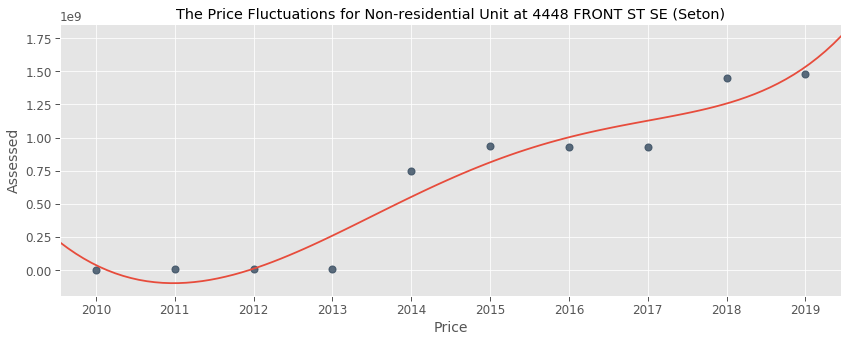

In [17]:
Unit_Price(Temp)

In [18]:
address_map(Temp, 14.5)

In [19]:
print('As can be seen the unit is a %s unit, and it is located in %s.' % (Temp.Assessment_Class_Description.tolist()[-1],
                                                                         Temp.Comm_Name.unique()[0])) 

As can be seen the unit is a Non-residential unit, and it is located in Seton.


## Average Price (the Current Year)

Now, let's analyze the asset value in each community 

In [20]:
def Community_Ave_yr(Yr=2019, Sort = True, Inp=Data, Boundaries = Community_Boundaries):
    Temp = Inp[Inp['Roll_Year']==Yr]
    Temp1 = Temp.groupby(['Comm_Code',
                             'Comm_Name', 'Assessment_Class_Description',
                             'Comm_Structure', 'Sector'])['Assessed_Value'].agg({'Average Value':'mean'}).reset_index() 
    Out = Temp1.merge(Boundaries [['Comm_Code', 'geometry']], how='right',
                     on='Comm_Code')
    del Temp, Temp1
    Out = Out[pd.notnull(Out['Average Value'])]
    if Sort:
        Out = Out.sort_values(by='Average Value', ascending=False)
    return Out 

In [21]:
Community_Ave_yr19 = Community_Ave_yr()
Community_Ave_yr19.head()

Comm_Code          Comm_Name Assessment_Class_Description Comm_Structure  \
208       DNW  Downtown West End      Machinery And Equipment    Centre City   
217       EAG        Eagle Ridge              Non-residential    1960S/1970S   
344       MEA    Meadowlark Park              Non-residential          1950S   
576       WWO        Wolf Willow                  Residential   Building Out   
460       SET              Seton              Non-residential   Building Out   

        Sector  Average Value  \
208     Centre   3.548500e+08   
217      South   1.092135e+08   
344     Centre   1.014148e+08   
576      South   6.217000e+07   
460  Southeast   5.419657e+07   

                                              geometry  
208  POLYGON ((-114.083172794772 51.050146402744, -...  
217  POLYGON ((-114.094887570319 50.989624951606, -...  
344  POLYGON ((-114.081197415744 51.001374863093, -...  
576  POLYGON ((-114.005267792647 50.87779102752, -1...  
460  POLYGON ((-113.929449830559 50.870782212559, -...

### Average Price (Non-residential)

We can consider those the have the highest asset values for non-residentials

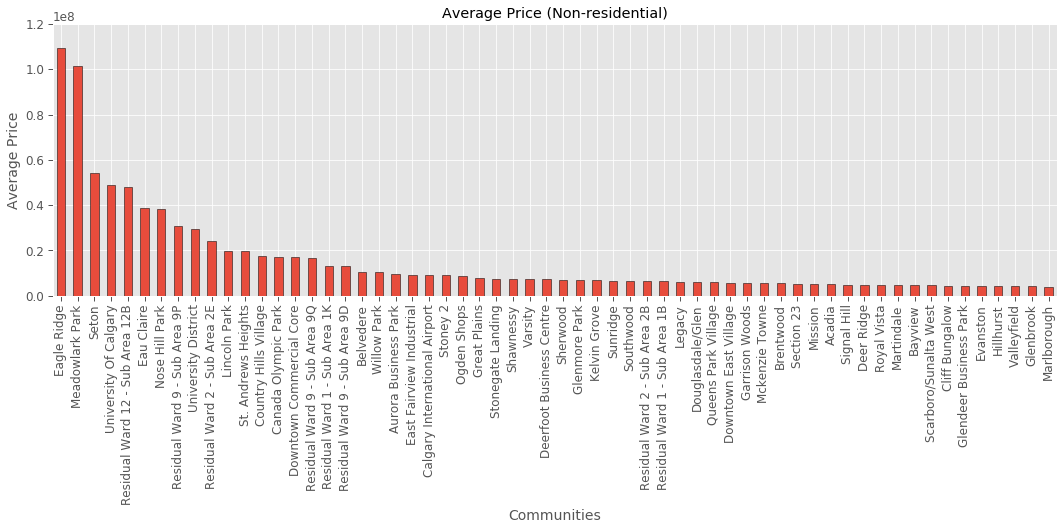

In [22]:
Class = 'Non-residential'
Temp = Community_Ave_yr19[Community_Ave_yr19.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5), sharex=False)
Temp.head(90).plot.bar(x='Comm_Name', y='Average Value', rot=90,ax=ax, legend=False, color='#e74c3c', edgecolor='k')
_ = ax.set_title('Average Price (%s)' % Class)
_ = ax.set_ylabel('Average Price')
_ = ax.set_xlabel('Communities')
_ = ax.set_ylim([0,1.2e8])

### Average Price (Residential)

Moreover, for residential, we have,

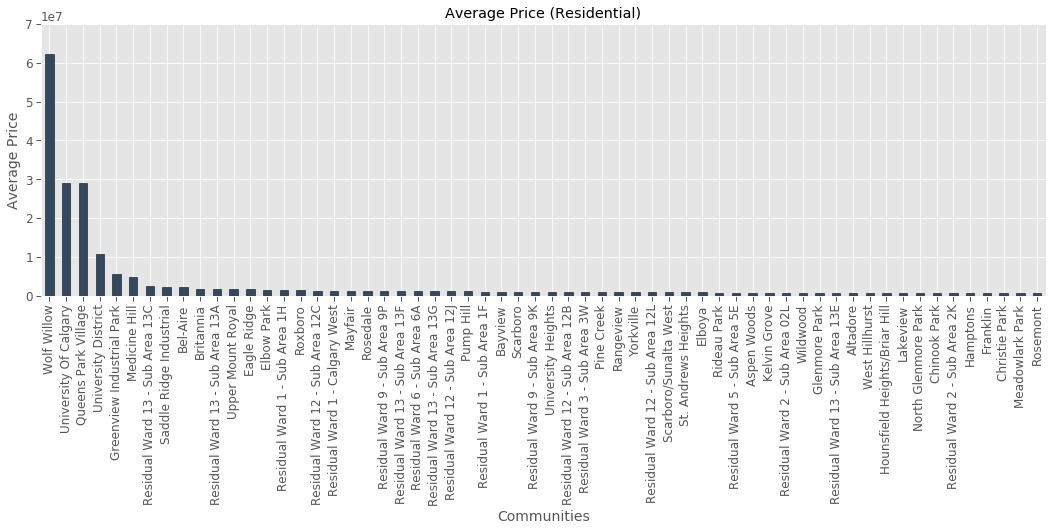

In [23]:
Class = 'Residential'
Temp = Community_Ave_yr19[Community_Ave_yr19.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5), sharex=False)
Temp.head(90).plot.bar(x='Comm_Name', y='Average Value', rot=90,ax=ax, legend=False ,color='#34495e', edgecolor='k')
_ = ax.set_title('Average Price (%s)' % Class)
_ = ax.set_ylabel('Average Price')
_ = ax.set_xlabel('Communities')
_ = ax.set_ylim([0,0.7e8])

### Average Price (Farmland)

Similartly,

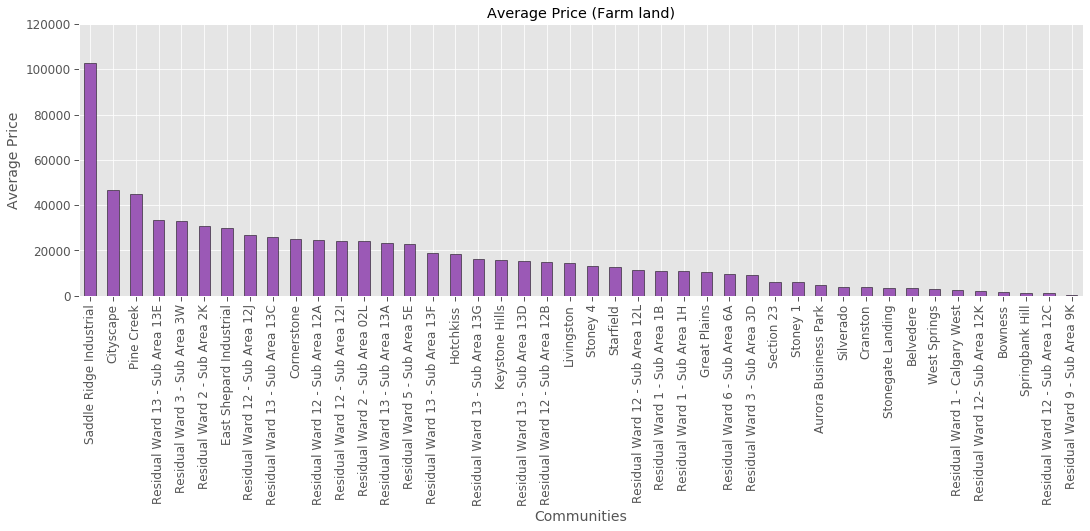

In [24]:
Class = 'Farm land'
Temp = Community_Ave_yr19[Community_Ave_yr19.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5), sharex=False)
Temp.head(90).plot.bar(x='Comm_Name', y='Average Value', rot=90,ax=ax, legend=False ,color='#9b59b6', edgecolor='k')
_ = ax.set_title('Average Price (%s)' % Class)
_ = ax.set_ylabel('Average Price')
_ = ax.set_xlabel('Communities')
_ = ax.set_ylim([0,1.2e5])

### Average Price (Machinery And Equipment)

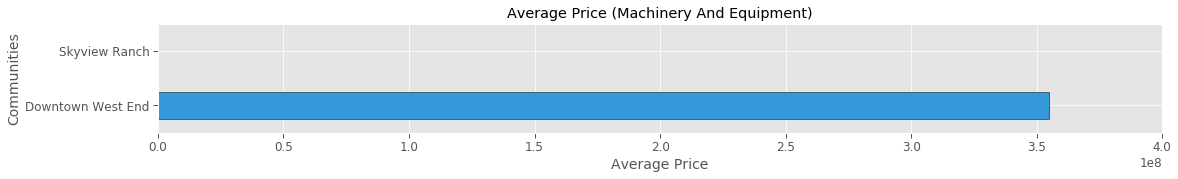

In [25]:
Class = 'Machinery And Equipment'
Temp = Community_Ave_yr19[Community_Ave_yr19.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 2), sharex=False)
Temp.head(90).plot.barh(x='Comm_Name', y='Average Value', rot=0,ax=ax, legend=False ,color='#3498db', edgecolor='k')
_ = ax.set_title('Average Price (%s)' % Class)
_ = ax.set_xlabel('Average Price')
_ = ax.set_ylabel('Communities')
_ = ax.set_xlim([0,4e8])

### Assessed Average Value by Sector

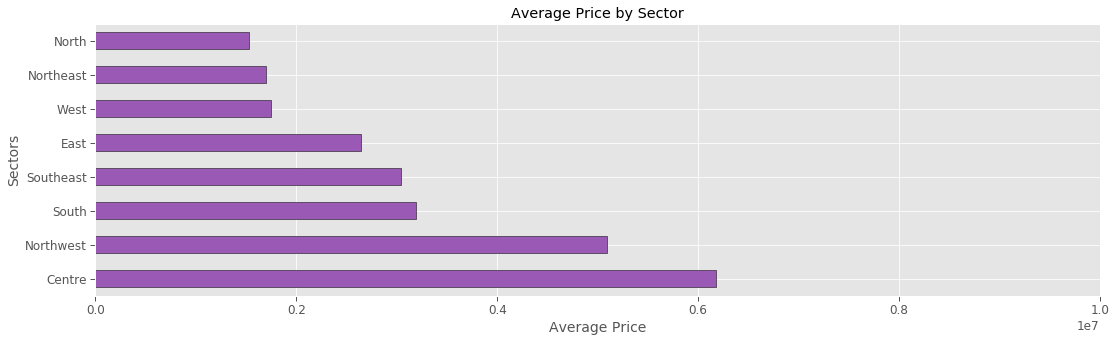

In [26]:
Temp = Community_Ave_yr19.groupby(['Sector'])['Average Value'].agg({'Average Value':'mean'}).reset_index()
Temp = Temp.sort_values(by='Average Value', ascending=False)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 5), sharex=False)
Temp.head(90).plot.barh(x='Sector', y='Average Value', rot=0,ax=ax, legend=False ,color='#9b59b6', edgecolor='k')
_ = ax.set_title('Average Price by Sector')
_ = ax.set_xlabel('Average Price')
_ = ax.set_ylabel('Sectors')
_ = ax.set_xlim([0,1e7])

### Assessed Average Value by Community Structure

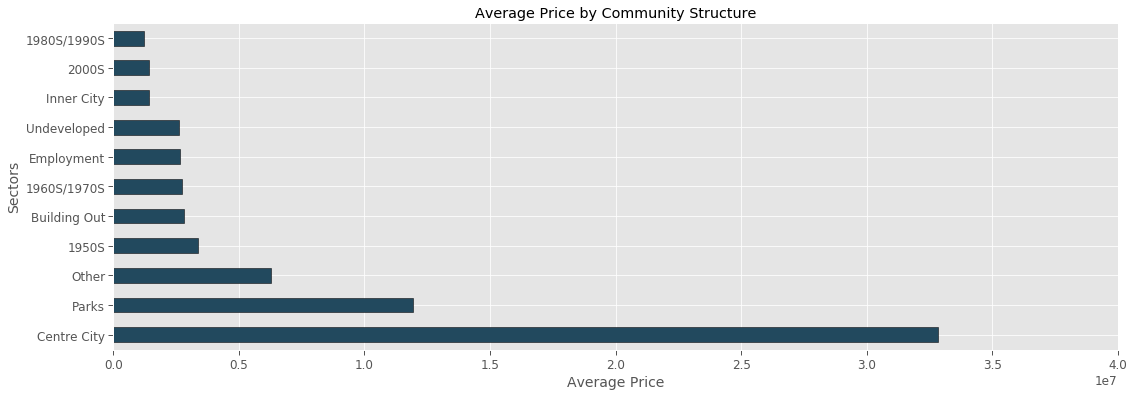

In [27]:
Temp = Community_Ave_yr19.groupby(['Comm_Structure'])['Average Value'].agg({'Average Value':'mean'}).reset_index()
Temp = Temp.sort_values(by='Average Value', ascending=False)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharex=False)
Temp.head(90).plot.barh(x='Comm_Structure', y='Average Value', rot=0,ax=ax, legend=False ,color='#22495e', edgecolor='k')
_ = ax.set_title('Average Price by Community Structure')
_ = ax.set_xlabel('Average Price')
_ = ax.set_ylabel('Sectors')
_ = ax.set_xlim([0,4e7])

## Maps

### Assessed Average Value by Community

In [28]:
def Community_Ave_yr(Yr=2019, Inp=Data):
    Temp = Data[Data['Roll_Year']==Yr]
    Out = Temp.groupby('Comm_Code')['Assessed_Value'].agg({'Average Value': 'mean'}).reset_index()
    del Temp
    Temp = pd.merge(Community_Boundaries, Out, how ='inner', on ='Comm_Code')
    Out = Temp.copy()
    del Temp
    Out = Out[['Average Value', 'geometry']]
    return Out 

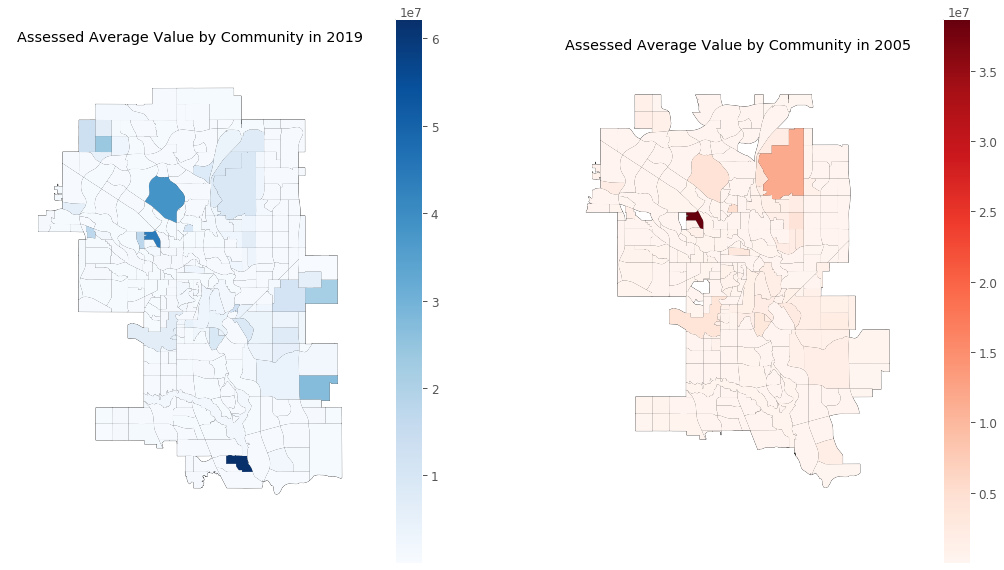

In [29]:
proj = gcrs.AlbersEqualArea(central_latitude = Data.Latitude.mean(), central_longitude = Data.Longitude.mean())
f, ax = plt.subplots(1, 2, figsize=(18, 10), subplot_kw={'projection': proj})

# Left Plot
Temp = Community_Ave_yr(Data.Roll_Year.max())
_ = gplt.choropleth(Temp, hue = 'Average Value', cmap='Blues', linewidth=0.0, ax = ax[0], legend=True)
_ = gplt.polyplot(Temp, edgecolor='black', linewidth=0.5, ax = ax[0])
_ = ax[0].set_title('Assessed Average Value by Community in 2019')
del Temp

# Right Plot
Temp = Community_Ave_yr(Data.Roll_Year.min())
_ = gplt.choropleth(Temp, hue = 'Average Value', cmap='Reds', linewidth=0.0, ax = ax[1], legend=True)
_ = gplt.polyplot(Temp, edgecolor='black', linewidth=0.5, ax = ax[1])
_ = ax[1].set_title('Assessed Average Value by Community in 2005')
del Temp 

### Asset Values in Each Community

We can define the following heatmap to show the Assessed values in each community. In each case, the to fifty most values asses are also marked on the map.

In [30]:
def map_points(df, Zoom = 13, TOP = 10, heat_map_weights_col='Assessed_Value', Normalize=False, heat_map_radius=10):
    
    M = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start = Zoom)
    if heat_map_weights_col is None:
        Cols = ['Latitude', 'Longitude']
    else:
        if Normalize:
            df[heat_map_weights_col] = df[heat_map_weights_col] / df[heat_map_weights_col].sum()
        Cols = ['Latitude', 'Longitude', heat_map_weights_col]
    
    M.add_child(plugins.HeatMap(df[Cols].values, radius=heat_map_radius))
    
    Tops = df.head(TOP)
    for i in range(len(Tops)):
        Inp=df[i:(i+1)]
        St = '(Value:' + str(Inp.Assessed_Value.values[0])+', Class:' + Inp.Assessment_Class_Description.values[0] + ')'
        if (Inp.Assessment_Class.values[0] == 'RE'):
            folium.Marker(location=[Inp.Latitude.values[0], Inp.Longitude.values[0]], popup = St,
                          icon=folium.Icon(color='purple',icon='building', prefix='fa') ).add_to(M)
        else:
            folium.Marker(location=[Inp.Latitude.values[0], Inp.Longitude.values[0]], popup = St).add_to(M)
            
    return M

In [31]:
Temp = Data[Data.Roll_Year == 2019]
Temp = Temp[Temp.Comm_Name == 'Seton']
map_points(Temp, 14, 50)

In [32]:
Temp = Data[Data.Roll_Year == 2019]
Temp = Temp[Temp.Comm_Name == 'Brentwood']
map_points(Temp, 14, 50)

# Predictions

Unfortunately, the given data are not suitable for any forms of predictions since we mainly know the location of an asset,  and their classes and values. Hopefully, in the future, this study can be extended.

See also [Property Assessment [King County]](https://hatefdastour.github.io/portfolio/property_assessment/property_assessment_King_County.html)

***